In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
loader = DataLoader()
d = loader.GetData('final')

In [7]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    for punct in [':',',','.','?',';',"'",'!']:
        essay = essay.replace(punct,punct+' ')
    cleaned = preproc(essay.replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

In [4]:
d = d.loc[d['score'] > 0,:]

In [ ]:
topics = {
    '19121413':'dormitory',
    '19121416':'reading',
    '19121417':'English',
    '19121435':'friends',
    '19121436':'langauge',
    '19121437':'parents',
    '19121438':'fit',
    '19121439':'homesickness',
    '19121440':'books',
    '1000561535':'internet'
}

In [28]:
sns.set_style('darkgrid')

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='token', ylabel='Count'>

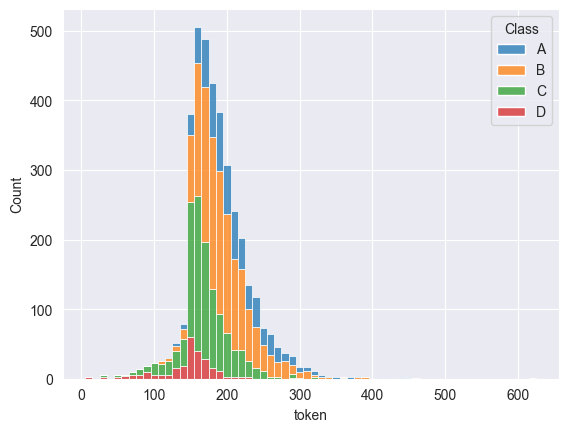

In [69]:
sns.histplot(d,x='token',hue='Class',multiple='stack',binwidth=10,hue_order=['A','B','C','D'])
#plt.legend(title='Grade',labels=['A','B','C','D'])

In [48]:
token = []
with open('features/final-winter-fine.csv') as f:
    raw = f.readlines()[1:3831]
for i in range(len(raw)):
    l = raw[i]
    l = l.rstrip('\n').split(',')[2:]
    l = [float(i) for i in l]
    if i in list(d.index):
        token.append(l[-7])
    else:
        token.append(0)

In [78]:
d[d['token'] == 5]['text']

1164                            I like reading very much.
2604    What are Consequences of Intemet addiction.kim...
Name: text, dtype: object

In [79]:
d['text'][2604]

'What are Consequences of Intemet addiction.kimiwananimo'

In [64]:
d['token'].describe()

count    3784.000000
mean      187.057347
std        43.617897
min         5.000000
25%       160.000000
50%       180.000000
75%       207.000000
max       625.000000
Name: token, dtype: float64

In [6]:
NLP = spacy.load('en_core_web_trf')
SuPar = Parser.load('crf-con-en')

In [3]:
#doc = NLP(d.iloc[0])
doc = NLP('I drank a cup of water that has some juice in it.')

In [9]:
s = [[token.text for token in sent if token.text] for sent in list(doc.sents)]

In [13]:
sent_trees = str(SuPar.predict(s[0],prob=True,verbose= False).sentences[0])
sent_trees

'(TOP (S (NP (_ I)) (VP (_ drank) (NP (NP (_ a) (_ cup)) (PP (_ of) (NP (_ water))) (SBAR (WHNP (_ that)) (S (VP (_ has) (NP (_ some) (_ juice)) (PP (_ in) (NP (_ it)))))))) (_ .)))'

In [14]:
a = nltk.Tree.fromstring(sent_trees)

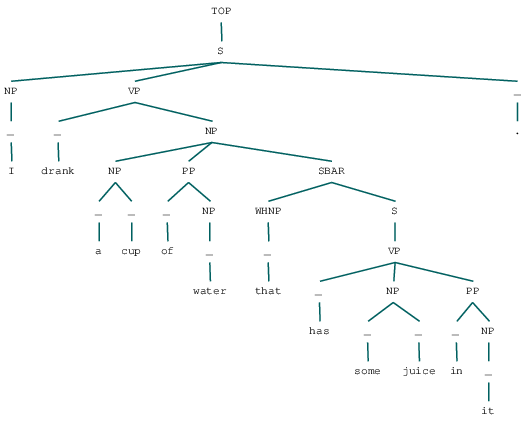

In [15]:
a

if labels of $n_1$ and $n_2$ are the same:
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
we are summing over all pairs of possible subsequences of children of all possible length (smaller than shorter tree length), allowing partial trees with gaps   
With decay factors :
$$
C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
$$
where
$$
d(J_1) = J_{1l(J_1)} - J_{1i} + 1
$$
if they are different:
$$
C(n_1,n_2) = 0
$$
The tree kernel of $T_1$ and $T_2$ is:
$$
K(T_1,T_2) = \sum_{t_1\in N_{T_1}}\sum_{t_2\in N_{T_2}}C(t_1,t_2)
$$
with normalization
$$
K_{norm}(T_1,T_2) = \dfrac{K(T_1,T_2)}{\sqrt{K(T_1,T_1) \times K(T_2,T_2)}}
$$

In [98]:
import math
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res
def KernelFunction(tree1,tree2,t1index,t2index,prev,tree1Index,tree2Index):
    # If already calculated, return result directly
    #print(t1index,t2index)
    if prev[t1index][t2index] != -1:
        return prev[t1index][t2index]
    # tree1 and tree2 are actually trees of token objects
    # get dep labels of all nodes, t1 and t2 are trees of dep labels
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i])
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i])
    # mu and lambda are decay factors, mu penalize tree height and lambda penalize tree length
    mu =0.9
    lambda_ = 0.9
    k = 0 # final sum
    if t1[0] == t2[0]: # if labels are the same
        max_tree_len = min(len(t1[1]),len(t2[1]))
        for tree_len in range(1,max_tree_len+1) :
            # length of all possible subtrees 
            #ChildSeqs = GetAllComb(tree_len,[c for c in range(min(len(t1[1]),len(t2[1])))])
            if max_tree_len <= 10:
                ChildSeqs = comb_dict[max_tree_len][tree_len]
            else:
                ChildSeqs = GetAllComb(tree_len,[c for c in range(max_tree_len)])
            #print(ChildSeqs)
            # list of indices of all possible child sequences of given length
            for j1 in ChildSeqs:
                for j2 in ChildSeqs:
                    # Get all pairs of sub sequences
                    #print(j1,j2)
                    prod = 1 # product
                    #print(len(j1),tree_len)
                    for i in range(tree_len):
                        childt1 = tree1[1][j1[i]] # token object
                        childt2 = tree2[1][j2[i]]
                        prodt1 = (childt1,[j for j in childt1.children if j.text.isalpha()]) # build subtree 
                        prodt2 = (childt2,[j for j in childt2.children if j.text.isalpha()])
                        #if prodt1[1] and prodt2[1]:
                        #print(prodt1,prodt2)
                        t1index = tree1Index[childt1]
                        t2index = tree2Index[childt2]
                        res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index) 
                        prod = prod * res
                        #if prev[t1index][t2index]  == -1:
                        prev[t1index][t2index] = res
                        #print(prod)
                        # continue matching subtree
                    # finish matching indices j1 and j2, sum 
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1    
                    k += ((lambda_) ** (dt1 + dt2)) * prod
        return mu * (lambda_**2 + k)
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    prev = [[-1 for i in range(len(tree2))] for j in range(len(tree1))]
    tree1Index = {list(tree1)[i]:i for i in range(len(tree1))}
    tree2Index = {list(tree2)[i]:i for i in range(len(tree2))}
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i.text.isalpha()])
        for tokent2 in tree2:
            # sum over all nodes
            prodt2 = (tokent2,[i for i in tokent2.children if i.text.isalpha()])
            if tokent1.text.isalpha() and (tokent1.dep_ == tokent2.dep_):
                #print('subtree',prodt1,prodt2)
                t1index = tree1Index[tokent1]
                t2index = tree2Index[tokent2]
                res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index)
                sim += res
                prev[t1index][t2index] = res
    return sim 
def normPTK(tree1,tree2):
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

In [ ]:
{list(sents[0])[i]:i for i in range(len(sents[0]))}

In [91]:
PartialTreeKernel(sents[10],sents[10])

29688.954416699304

In [111]:
doc =simnlp(d['text'][2984])
sents = list([i for i in doc.sents if len(str(i).strip()) > 5])

In [112]:
sim_matrix= np.eye(len(sents),len(sents))
lm_sim = np.eye(len(sents),len(sents))
self_sim = []
trps = []
for i in range(len(sents)):
    self_sim.append(PartialTreeKernel(sents[i],sents[i]))
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])
        lm_sim[i,j] = sents[i].similarity(sents[2])
        trps.append((sents[i],sents[j],sim_matrix[i,j]))
#sorted(trps,key=lambda x:x[2],reverse=True)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_7772\4028163011.py:11: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  lm_sim[i,j] = sents[i].similarity(sents[2])


In [113]:
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        if sim_matrix[i,j]  > lm_sim[i,j] :
            print(sents[i],sents[j])

In [ ]:
for i in range(150):
    doc =simnlp(d['text'][i])
    sents = list([i for i in doc.sents if len(str(i).strip()) > 5])
    sim_matrix= np.eye(len(sents),len(sents))
    lm_sim = np.eye(len(sents),len(sents))
    self_sim = []
    for i in range(len(sents)):
        self_sim.append(PartialTreeKernel(sents[i],sents[i]))
    for i in range(len(sents)):
        for j in range(i+1,len(sents)):
            sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])
            lm_sim[i,j] = sents[i].similarity(sents[2])
            if sim_matrix[i,j]  > lm_sim[i,j] + 0.2 :
                print(sim_matrix[i,j],lm_sim[i,j],sents[i],sents[j])

In [81]:
simnlp = spacy.load('en_core_web_sm')

In [119]:
doc1 = simnlp('I ate the orange that you gave me')
doc2 = simnlp('She refused the advice that he offered her')

In [120]:
normPTK(doc1,doc2)

1.0

In [121]:
doc1.similarity(doc2)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_7772\2159000743.py:1: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  doc1.similarity(doc2)


0.8152315616607666

In [8]:
vacs = []
for i in range(len(d)):
    doc = NLP(d['text'][i])
    for s in doc.sents:
        if len(str(s).split()) > 3:
            sentVAC = [s,[]]
            for t in s:
                if 'V' in t.tag_ and t.text.isalpha():
                    left = [m.dep_ for m in t.lefts if m.text.isalpha()]
                    right = [m.dep_ for m in t.rights if m.text.isalpha()]
                    verbvac = '_'.join(left) + '_V_{}_'.format(t.lemma_) + '_'.join(right)
                    sentVAC[1].append(verbvac)
            vacs.append(sentVAC)
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800


In [70]:
import re
match = []
patterns = {'[a-z_]*V[a-z_]*acomp[a-z_]*':'-acomp',
            '[a-z_]*V_[a-z]*_\Z':'-',
            '[a-z_]*V_[a-z_]*(conj)|(cc)\Z':'-',
            '[a-z_]*V_[a-z]*[a-z_]*adv[a-z]*\Z':'-advmod',
            '[a-z_]*V[a-z_]*prt[a-z_]*':'-particle',
            '[a-z_]*V[a-z_]*attr[a-z_]*':'-attr',
            '[a-z_]*V[a-z_]*oprd[a-z_]*':'-oprd',
            '[a-z_]*V[a-z_]*dobj[a-z_]*':'-dobj',
            '[a-z_]*V[a-z_]*(pobj)|(pcomp)[a-z_]*':'-dobj',
            '[a-z_]*V[a-z_]*prep':'-prep',
            '[a-z_]*V[a-z_]*ccomp[a-z_]*':'-ccomp',
            '[a-z_]*V[a-z_]*xcomp[a-z_]*':'-xcomp',
            '[a-z_]*V[a-z_]*dative[a-z_]*':'-dative-dobj',
            '[a-z_]*V[a-z_]*dobj[a-z_]*prep\Z':'-dobj-prep',
            '[a-z_]*V[a-z_]*nsubj[a-z_]*':'-inversion',
            '[a-z_]*V[a-z_]*agent[a-z_]*':'-passive',
            '[a-z_]*V[a-z_]*intj[a-z_]*':'-intj',
            'expl_V_be[a-z_]*':'-there'}
for i in vacs:
    for v in i[1]:
        vaclist = v.split('_')
        verb = vaclist[vaclist.index('V')+1]
        for p in patterns:
            res = re.findall(p,v)
            if res:
                match.append((v,'{}{}'.format(verb,patterns[p])))
                break
        if not res:
            match.append((i,'{}-other'.format(v)))
len([i for i in match if '-other' in i[1] and not 'dep' in i[1]])
#match

63

In [66]:
[i.dep_ for i in NLP('The problem is that he is dying')]

['det', 'nsubj', 'ROOT', 'mark', 'nsubj', 'aux', 'ccomp']

+ subject + verb + clausal complement
  + nsubj_V_ccomp 
+ subject + verb + attribute
  + nsubj_V_attr
+ subject + verb + direct object
  + nsubj_V_dobj
+ subject + verb + open clausal complement
  + nsubj_V_xcomp
+ subject + verb + preposition
  + nsubj_V_prep
+ expletive + verb + attribute
  + expl_V_attr
+ clausal subject + verb + *
  + csubj_V

In [2]:
t = '''ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp'''
for s in t.split(','):
    print(s,spacy.explain(s.strip()))


ROOT root
 acl clausal modifier of noun (adjectival clause)
 acomp adjectival complement
 advcl adverbial clause modifier
 advmod adverbial modifier
 agent agent
 amod adjectival modifier
 appos appositional modifier
 attr attribute
 aux auxiliary
 auxpass auxiliary (passive)
 case case marking
 cc coordinating conjunction
 ccomp clausal complement
 compound compound
 conj conjunct
 csubj clausal subject
 csubjpass clausal subject (passive)
 dative dative
 dep unclassified dependent
 det determiner
 dobj direct object
 expl expletive
 intj interjection
 mark marker
 meta meta modifier
 neg negation modifier
 nmod modifier of nominal
 npadvmod noun phrase as adverbial modifier
 nsubj nominal subject
 nsubjpass nominal subject (passive)
 nummod numeric modifier
 oprd object predicate
 parataxis parataxis
 pcomp complement of preposition
 pobj object of preposition
 poss possession modifier
 preconj pre-correlative conjunction
 predet None
 prep prepositional modifier
 prt particle
 punct

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\glossary.py:19: UserWarning: [W118] Term 'predet' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))
